In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date
from datetime import timedelta

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
df=pd.read_csv("2017_Yellow_Taxi_Trip_Data (1).csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [4]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [7]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
std,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000


**Observations:**
1. Outliers found in trip_distance, fare_amount, tip_amount, total_amount should be further investigated.
2. There are -ve values in fare and total_amount deal with them.
3. extra, mta_tax, imporvement_surcharge have values near to zero,  which would imply that they would not be expected to be very predictive.
4. RatecodeID has unusual value of 99, check it
5. There are trips with passenger count 0.(may be cancelled trips)
6. There are trips with trip_distance = 0 

In [8]:
df =df[df['RatecodeID']!=99]

In [9]:
# Convert datetime columns to datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

In [10]:
# creating duration variable in minutes
df['duration']= (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

In [11]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667
1,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000
2,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000
3,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000
4,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,16.716667


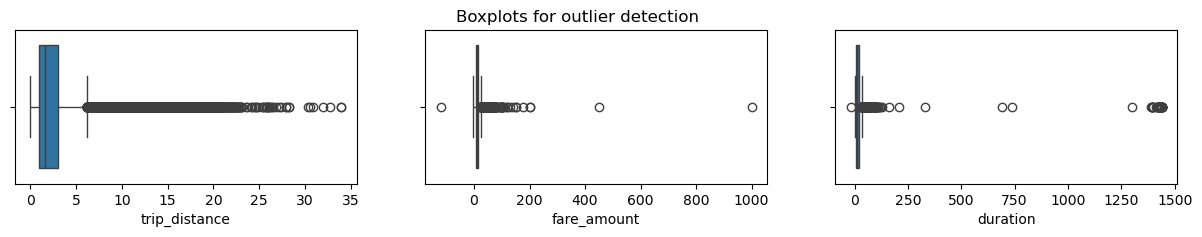

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df['trip_distance'])
sns.boxplot(ax=axes[1], x=df['fare_amount'])
sns.boxplot(ax=axes[2], x=df['duration'])
plt.show();

1. All three variables contain outliers. Some are extreme, but others not so much.
2. It's 30 miles from the southern tip of Staten Island to the northern end of Manhattan and that's in a straight line. With this knowledge and the distribution of the values in this column, it's reasonable to leave these values alone and not alter them. However, the values for fare_amount and duration definitely seem to have problematic outliers on the higher end.
3. Probably not for the latter two, but for trip_distance it might be okay

In [13]:
# Outlier Imputation

# trip_duration
sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

In [14]:
df.shape

(22698, 18)

In [15]:
# check how many trips with trip_distance = 0 out off 222698
sum(df['trip_distance']==0)

147

As the number is very low imputing them will not effect the model.

In [16]:
# fare_amount
df['fare_amount'].describe()

count    22698.000000
mean        13.023802
std         13.237230
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

In [17]:
# Impute values less than $0 with 0
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
df['fare_amount'].min()

0.0

In [18]:
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

In [19]:
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22698.000000
mean        12.895727
std         10.536226
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



In [20]:
# duration
df['duration'].describe()

count    22698.000000
mean        17.014526
std         61.997745
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

In [21]:
# Impute a 0 for any negative values
df.loc[df['duration'] < 0, 'duration'] = 0

# Impute the high outliers
outlier_imputer(['duration'], 6)

duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22698.000000
mean        14.461192
std         11.946920
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64



### feature engineering

create a feature to identify unique pickup and dropoff pairs and their corresponding mean_distance and mean_duration

In [22]:
# Create `pickup_dropoff` column
df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]
grouped[:5]

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [23]:
# 1. Convert `grouped` to a dictionary
grouped_dict = grouped.to_dict()

# 2. Reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']

In [24]:
# mean_distance
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
df['mean_distance'] = df['pickup_dropoff']

# 2. Map `grouped_dict` to the `mean_distance` column
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

# Confirm that it worked
df[(df['PULocationID']==100) & (df['DOLocationID']==231)][['mean_distance']]

,mean_distance
0,3.521667
4909,3.521667
16636,3.521667
18134,3.521667
19761,3.521667
20581,3.521667


In [25]:
# mean_duration
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['duration']]
grouped

# Create a dictionary where keys are unique pickup_dropoffs and values are
# mean trip duration for all trips with those pickup_dropoff combos
grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['duration']

df['mean_duration'] = df['pickup_dropoff']
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

# Confirm that it worked
df[(df['PULocationID']==100) & (df['DOLocationID']==231)][['mean_duration']]

,mean_duration
0,22.847222
4909,22.847222
16636,22.847222
18134,22.847222
19761,22.847222
20581,22.847222


In [26]:
# Create 'day' col
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

# Create 'month' col
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [27]:
# Create 'rush_hour' col
df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

# If day is Saturday or Sunday, impute 0 in `rush_hour` column
df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

In [28]:
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [29]:
df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)
df.head()

/var/folders/mh/p31c9s4j7x96gcg6jjhwgmd00000gn/T/ipykernel_7460/75387958.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0 1 1 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
0,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,...,0.0,0.3,16.56,14.066667,100 231,3.521667,22.847222,saturday,mar,0
1,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,...,0.0,0.3,20.80,26.500000,186 43,3.108889,24.470370,tuesday,apr,0
2,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,...,0.0,0.3,8.75,7.200000,262 236,0.881429,7.250000,friday,dec,1
3,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,...,0.0,0.3,27.69,30.250000,188 97,3.700000,30.250000,sunday,may,0
4,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,...,0.0,0.3,17.80,16.716667,4 112,4.435000,14.616667,saturday,apr,0


#### Visualisations

<Axes: xlabel='mean_duration', ylabel='fare_amount'>

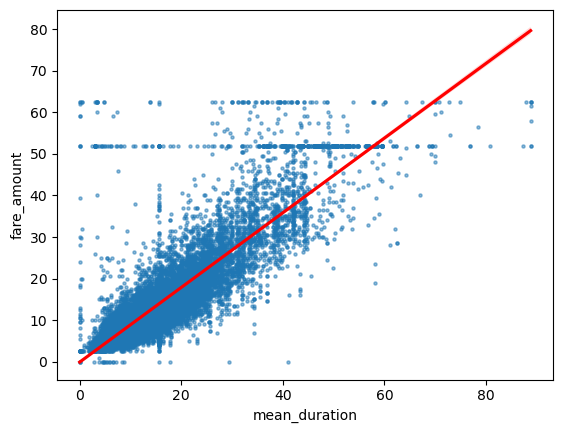

In [30]:
sns.regplot(x=df['mean_duration'], y=df['fare_amount'],
            scatter_kws={'alpha':0.5, 's':5},
            line_kws={'color':'red'})

In [31]:
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    514
62.5     83
59.0      9
50.5      9
57.5      8
Name: count, dtype: int64

In [32]:
df[df['fare_amount']==52][['pickup_dropoff','RatecodeID','tip_amount','tolls_amount','total_amount']]

,pickup_dropoff,RatecodeID,tip_amount,tolls_amount,total_amount
11,236 132,2,14.58,5.54,72.92
110,132 163,2,0.00,0.00,52.80
161,132 132,2,0.00,0.00,52.80
247,132 79,2,0.00,0.00,52.80
379,132 234,2,14.64,5.76,73.20
...,...,...,...,...,...
22593,211 132,2,0.00,0.00,57.30
22604,230 132,2,0.00,5.54,58.34
22620,132 261,2,5.50,0.00,58.30
22686,170 70,1,14.84,5.54,74.18


1. \\$62.5 indicating the outlier imputation done.
2. \\$52 trips have location 132 as either starting or ending point and RatecodeID 2 indicating the trips to JFK
3. In 2017 (the year that this data was collected) there was indeed a flat fare for taxi trips between JFK airport (in Queens) and Manhattan.

In [33]:
df['tip_amount'].describe()

count    22698.000000
mean         1.835862
std          2.800661
min          0.000000
25%          0.000000
50%          1.350000
75%          2.450000
max        200.000000
Name: tip_amount, dtype: float64

### Feature selection

In [68]:
# from previous anova test we have seen that RatecodeID and passenger_count have significant effect on fare_amount
df2 = df.copy()

df2 = df2.drop(['tpep_dropoff_datetime', 'tpep_pickup_datetime',
               'trip_distance', 'VendorID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
               'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
               'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'duration',
               'pickup_dropoff', 'day', 'month'
               ], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22698 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  22698 non-null  int64  
 1   RatecodeID       22698 non-null  int64  
 2   fare_amount      22698 non-null  float64
 3   mean_distance    22698 non-null  float64
 4   mean_duration    22698 non-null  float64
 5   rush_hour        22698 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.7 MB


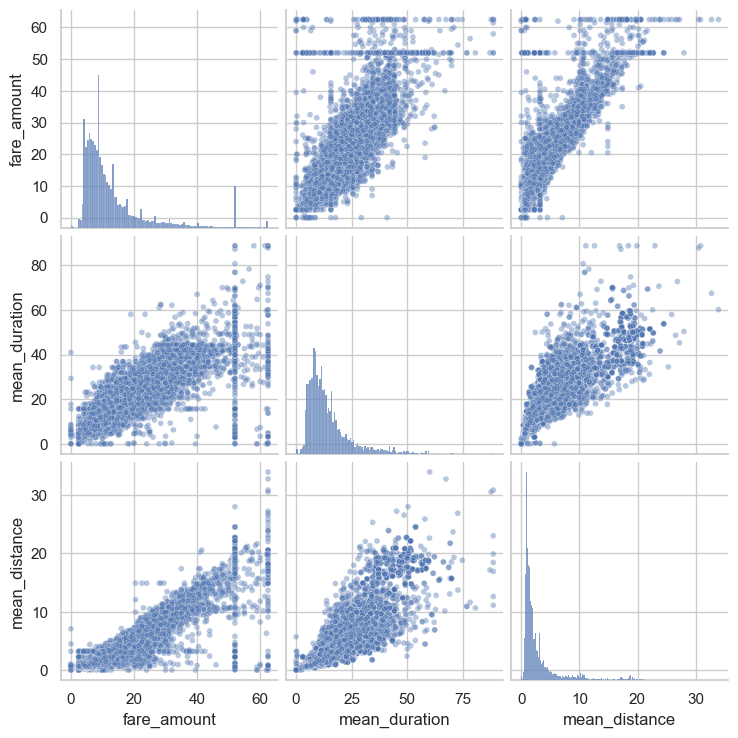

In [50]:
sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']],
             plot_kws={'alpha':0.4, 'size':5},
             );

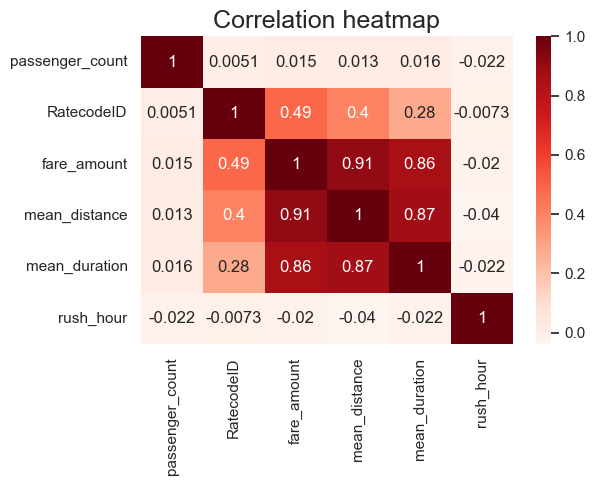

In [51]:
# Create correlation heatmap

plt.figure(figsize=(6,4))
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap',
          fontsize=18)
plt.show()

highly correlated predictor variables can be bad for linear regression models when you want to be able to draw statistical inferences about the data from the model. However, correlated predictor variables can still be used to create an accurate predictor if the prediction itself is more important than using the model as a tool to learn about your data.

### train_test_split

In [52]:
# Remove the target column from the features
X = df2.drop(columns=['fare_amount'])

# Set y variable
y = df2[['fare_amount']]

# Display first few rows
X.head()

,passenger_count,RatecodeID,mean_distance,mean_duration,rush_hour
0,6,1,3.521667,22.847222,0
1,1,1,3.108889,24.470370,0
2,1,1,0.881429,7.250000,1
3,1,1,3.700000,30.250000,0
4,1,1,4.435000,14.616667,0


In [55]:
# Convert VendorID to string
X['RatecodeID'] = X['RatecodeID'].astype(str)

# Get dummies
X = pd.get_dummies(X, drop_first=True)
X.head()

,passenger_count,mean_distance,mean_duration,rush_hour,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5
0,6,3.521667,22.847222,0,False,False,False,False
1,1,3.108889,24.470370,0,False,False,False,False
2,1,0.881429,7.250000,1,False,False,False,False
3,1,3.700000,30.250000,0,False,False,False,False
4,1,4.435000,14.616667,0,False,False,False,False


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Standardize the X variables
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
print('X_train scaled:', X_train_scaled)

X_train scaled: [[-0.50194827  0.87196338  0.17626931 ... -0.04331242 -0.02099456
  -0.05410516]
 [-0.50194827 -0.60116752 -0.69856659 ... -0.04331242 -0.02099456
  -0.05410516]
 [ 0.2728861  -0.47905202 -0.57323627 ... -0.04331242 -0.02099456
  -0.05410516]
 ...
 [-0.50194827 -0.45190626 -0.67915411 ... -0.04331242 -0.02099456
  -0.05410516]
 [-0.50194827 -0.59047657 -0.85777461 ... -0.04331242 -0.02099456
  -0.05410516]
 [ 1.82255483  0.83915443  1.13263183 ... -0.04331242 -0.02099456
  -0.05410516]]


In [57]:
# Fit your model to the training data
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [58]:
# Evaluate the model performance on the training data
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.870922716637595
R^2: 0.870922716637595
MAE: 2.1948675628141725
MSE: 14.307920462695268
RMSE: 3.7825811904961495


In [59]:
# Scale the X_test data
X_test_scaled = scaler.transform(X_test)

In [60]:
# Evaluate the model performance on the testing data
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.8719793660063964
R^2: 0.8719793660063964
MAE: 2.2326468744259325
MSE: 14.291946601414264
RMSE: 3.78046909806366


The model performance is high on both training and test sets, suggesting that there is little bias in the model and that the model is not overfit. In fact, the test scores were even better than the training scores.
For the test data, an R2 of 0.871 means that 87.1% of the variance in the fare_amount variable is described by the model.

In [61]:
results = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
5818,14.0,12.105156,1.894844
18134,28.0,16.334848,11.665152
4655,5.5,6.816858,-1.316858
7378,15.5,15.510944,-0.010944
19027,42.0,35.245033,6.754967


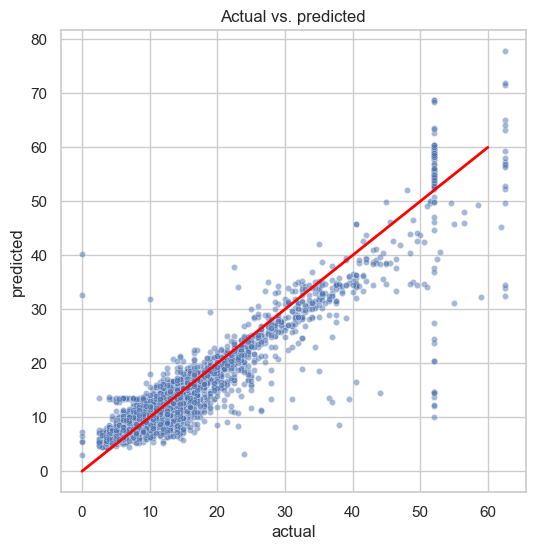

In [62]:
# Create a scatterplot to visualize `predicted` over `actual`
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',
                y='predicted',
                data=results,
                s=20,
                alpha=0.5,
                ax=ax
)
# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title('Actual vs. predicted');

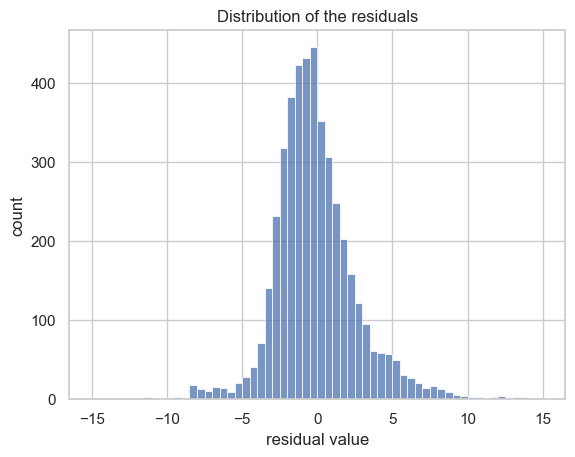

In [63]:
# Visualize the distribution of the `residuals`
sns.histplot(results['residual'], bins=np.arange(-15,15.5,0.5))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

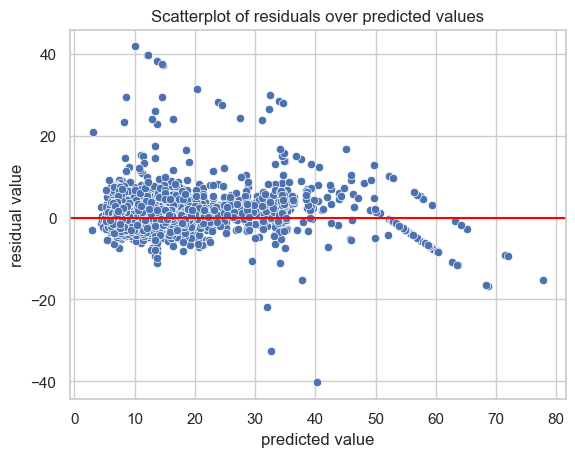

In [64]:
# Create a scatterplot of `residuals` over `predicted`

sns.scatterplot(x='predicted', y='residual', data=results)
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

In [65]:
coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients
#he data used to train the model was standardized with StandardScaler(). As such, the units are no longer miles. 

,passenger_count,mean_distance,mean_duration,rush_hour,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5
0,0.013165,5.917671,3.331423,0.092692,1.012777,0.651894,0.20752,1.435775


In [67]:
# 1. Calculate SD of `mean_distance` in X_train data
print(X_train['mean_distance'].std())

# 2. Divide the model coefficient by the standard deviation
print(7.133867 / X_train['mean_distance'].std())

3.566199040131589
2.0004119006595795


Now you can make a more intuitive interpretation: for every 3.56 miles traveled, the fare increased by a mean of \\$5.91. Or, reduced: for every 1 mile traveled, the fare increased by a mean of \\$2.00.

### Observations
1. When the mean_distance and mean_duration columns were computed, the means were calculated from the entire dataset. These same columns were then used to train a model that was used to predict on a test set. A test set is supposed to represent entirely new data that the model has not seen before, but in this case, some of its predictor variables were derived using data that was in the test set. This is known as data leakage. Data leakage is when information from your training data contaminates the test data. If your model has unexpectedly high scores, there is a good chance that there was some data leakage. To avoid data leakage in this modeling process, it would be best to compute the means using only the training set and then copy those into the test set, thus preventing values from the test set from being included in the computation of the means. This would have created some problems because it's very likely that some combinations of pickup-dropoff locations would only appear in the test data (not the train data). This means that there would be NaNs in the test data, and further steps would be required to address this.
2. Imputing the fare amount for RatecodeID 2 after training the model and then calculating model performance metrics on the post-imputed data is not best practice. It would be better to separate the rides that did not have rate codes of 2, train the model on that data specifically, and then add the RatecodeID 2 data (and its imputed rates) after. This would prevent training the model on data that you don't need a model for, and would likely result in a better final model. However, the steps were combined for simplicity.